# Initialisation

In [2]:
import pandas as pd
import numpy as np 
import math
import matplotlib.pyplot as plt
import json

import time
start_time = time.time()

In [3]:
LoadFR = pd.read_csv("Total Load - Day Ahead _ Actual_202301010000-202401010000 FR.csv")
#LoadFR

In [4]:
LoadDE = pd.read_csv("Total Load - Day Ahead _ Actual_202301010000-202401010000 DE.csv")
#LoadDE

In [5]:
ProdFR = pd.read_csv("Actual Generation per Production Type_202301010000-202401010000 FR.csv")
#ProdFR

In [6]:
ProdDE = pd.read_csv("Actual Generation per Production Type_202301010000-202401010000 DE.csv")
#ProdDE

In [7]:
habDE=83.2e6+0.640e6
habFR=67.75e6

In [8]:
ProdDE.columns

Index(['Area', 'MTU', 'Biomass  - Actual Aggregated [MW]',
       'Fossil Brown coal/Lignite  - Actual Aggregated [MW]',
       'Fossil Coal-derived gas  - Actual Aggregated [MW]',
       'Fossil Gas  - Actual Aggregated [MW]',
       'Fossil Hard coal  - Actual Aggregated [MW]',
       'Fossil Oil  - Actual Aggregated [MW]',
       'Fossil Oil shale  - Actual Aggregated [MW]',
       'Fossil Peat  - Actual Aggregated [MW]',
       'Geothermal  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Consumption [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]',
       'Marine  - Actual Aggregated [MW]', 'Nuclear  - Actual Aggregated [MW]',
       'Other  - Actual Aggregated [MW]',
       'Other renewable  - Actual Aggregated [MW]',
       'Solar  - Actual Aggregated [MW]', 'Waste  - Actual Aggregated [MW]',
       'Wind Offshore  - Actual 

In [9]:
colRen=[ProdDE.columns[2],ProdDE.columns[10] ,ProdDE.columns[11], ProdDE.columns[13], 
     ProdDE.columns[14],ProdDE.columns[15], ProdDE.columns[17], ProdDE.columns[18], ProdDE.columns[19],
     ProdDE.columns[20], ProdDE.columns[21], ProdDE.columns[22]]
#col

In [10]:
colRenScalable=[ProdDE.columns[19], ProdDE.columns[21], ProdDE.columns[22]]
colRenScalable

['Solar  - Actual Aggregated [MW]',
 'Wind Offshore  - Actual Aggregated [MW]',
 'Wind Onshore  - Actual Aggregated [MW]']

# Production /hab necessaire des renouvelables solaires et éoliennes pour atteindre moins de 10% de temps de sous-production en exclusivement renouvelable en fonction de la capacité de stockage ideal /hab - FR

In [11]:
timeProdRenFR = ProdFR[colRen].sum(numeric_only = True, axis=1)
#timeProdFR

In [12]:
timeProdRenScalableFR = ProdFR[colRenScalable].sum(numeric_only = True, axis=1)
#timeProdRenScalableFR

In [13]:
Estockage = pd.Series()
Pstockage = pd.Series()

In [14]:
#Ehab=0.001

In [15]:
ErenIncFR= []
j = -1
Eval = [0.000125, 0.00025, 0.0005, 0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128]
for Ehab in Eval:
    j += 1

    Emax=Ehab*habFR
    Pmax=Emax/10

    FactorFR = 1
    result = 20
    while result > 10:
        FactorFR += 0.1
        E = Emax/2

        SurProdFR = timeProdRenFR + timeProdRenScalableFR * FactorFR - LoadFR['Actual Total Load [MW] - BZN|FR']
        # Some NaN values may create problem, replace them by zero to fix the bug
        SurProdFR = [0 if math.isnan(x) else x for x in SurProdFR]

        for i,val in enumerate(SurProdFR):
            if SurProdFR[i] > 0:
                Pstockage[i] = -min(SurProdFR[i], Pmax, Emax-E)
                E = E-Pstockage[i]
            else:
                Pstockage[i] = min(-SurProdFR[i], Pmax, E)
                E = E-Pstockage[i]
            Estockage[i] = E
            #print(E)
         #Pstockage

        Pstockage = Pstockage + 1 #Ajoute 1 pour clarifier l'inégalité ci-dessous
        timeSousProdRenFR_stockage_temp = timeProdRenFR + timeProdRenScalableFR * FactorFR + Pstockage < LoadFR['Actual Total Load [MW] - BZN|FR']
        #sum(timeSousProdRenFR_temp.astype(int))
        LoadFR_reduced = LoadFR['Actual Total Load [MW] - BZN|FR'].mul(0.9 * timeSousProdRenFR_stockage_temp.astype(int), axis=0) + LoadFR['Actual Total Load [MW] - BZN|FR'].mul(1-timeSousProdRenFR_stockage_temp.astype(int), axis=0)
        timeSousProdRenFR_Stockage_LoadReduction = timeProdRenFR + timeProdRenScalableFR * FactorFR + Pstockage < LoadFR_reduced

        result = sum(timeSousProdRenFR_Stockage_LoadReduction) / len(ProdFR)*100
        result
    ErenIncFR.append(FactorFR)
ErenIncFR

[13.699999999999969,
 13.39999999999997,
 12.899999999999972,
 11.799999999999976,
 9.599999999999984,
 6.999999999999992,
 5.999999999999996,
 5.599999999999997,
 5.099999999999999,
 4.7,
 4.100000000000002]

In [16]:
Eval = [x * 1000 for x in Eval]

In [17]:
Eval

[0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0]

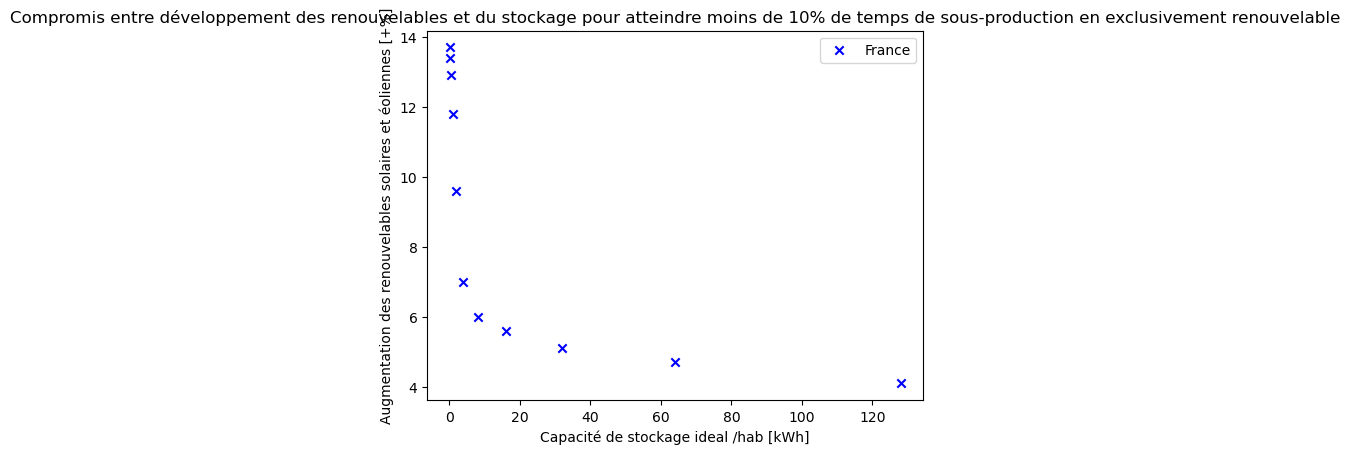

In [18]:
plt.scatter(Eval,ErenIncFR, c='b', marker='x', label='France')
plt.legend(loc='upper right')
plt.title("Compromis entre développement des renouvelables et du stockage pour atteindre moins de 10% de temps de sous-production en exclusivement renouvelable")
plt.xlabel("Capacité de stockage ideal /hab [kWh]")
plt.ylabel("Augmentation des renouvelables solaires et éoliennes [+%]")
plt.show()

# Production /hab necessaire des renouvelables solaires et éoliennes pour atteindre moins de 10% de temps de sous-production en exclusivement renouvelable en fonction de la capacité de stockage ideal /hab - DE

In [19]:
timeProdRenDE = ProdDE[colRen].sum(numeric_only = True, axis=1)
#timeProdDE

In [20]:
timeProdRenScalableDE = ProdDE[colRenScalable].sum(numeric_only = True, axis=1)
#timeProdRenScalableDE

In [21]:
Estockage = pd.Series()
Pstockage = pd.Series()

In [22]:
#Ehab=0.001

In [23]:
ErenIncDE= []
j = -1
Eval = [0.000125, 0.00025, 0.0005, 0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128]
for Ehab in Eval:
    j += 1

    Emax=Ehab*habDE
    Pmax=Emax/10

    FactorDE = 1
    result = 20
    while result > 10:
        FactorDE += 0.1
        E = Emax/2

        SurProdDE = timeProdRenDE + timeProdRenScalableDE * FactorDE - LoadDE['Actual Total Load [MW] - BZN|DE-LU']
        # Some NaN values may create problem, replace them by zero to fix the bug
        SurProdDE = [0 if math.isnan(x) else x for x in SurProdDE]

        for i,val in enumerate(SurProdDE):
            if SurProdDE[i] > 0:
                Pstockage[i] = -min(SurProdDE[i], Pmax, Emax-E)
                E = E-Pstockage[i]
            else:
                Pstockage[i] = min(-SurProdDE[i], Pmax, E)
                E = E-Pstockage[i]
            Estockage[i] = E
            #print(E)
         #Pstockage

        Pstockage = Pstockage + 1 #Ajoute 1 pour clarifier l'inégalité ci-dessous
        timeSousProdRenDE_stockage_temp = timeProdRenDE + timeProdRenScalableDE * FactorDE + Pstockage < LoadDE['Actual Total Load [MW] - BZN|DE-LU']
        #sum(timeSousProdRenDE_temp.astype(int))
        LoadDE_reduced = LoadDE['Actual Total Load [MW] - BZN|DE-LU'].mul(0.9 * timeSousProdRenDE_stockage_temp.astype(int), axis=0) + LoadDE['Actual Total Load [MW] - BZN|DE-LU'].mul(1-timeSousProdRenDE_stockage_temp.astype(int), axis=0)
        timeSousProdRenDE_Stockage_LoadReduction = timeProdRenDE + timeProdRenScalableDE * FactorDE + Pstockage < LoadDE_reduced

        result = sum(timeSousProdRenDE_Stockage_LoadReduction) / len(ProdDE)*100
        result
    ErenIncDE.append(FactorDE)
ErenIncDE

[5.099999999999999,
 5.099999999999999,
 4.999999999999999,
 4.7,
 4.200000000000002,
 3.300000000000002,
 2.5000000000000013,
 1.9000000000000008,
 1.5000000000000004,
 1.3000000000000003,
 1.1]

In [24]:
Eval = [x * 1000 for x in Eval]
ErenIncFR = [x * 100 for x in ErenIncFR]
ErenIncDE = [x * 100 for x in ErenIncDE]

In [25]:
Eval

[0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0]

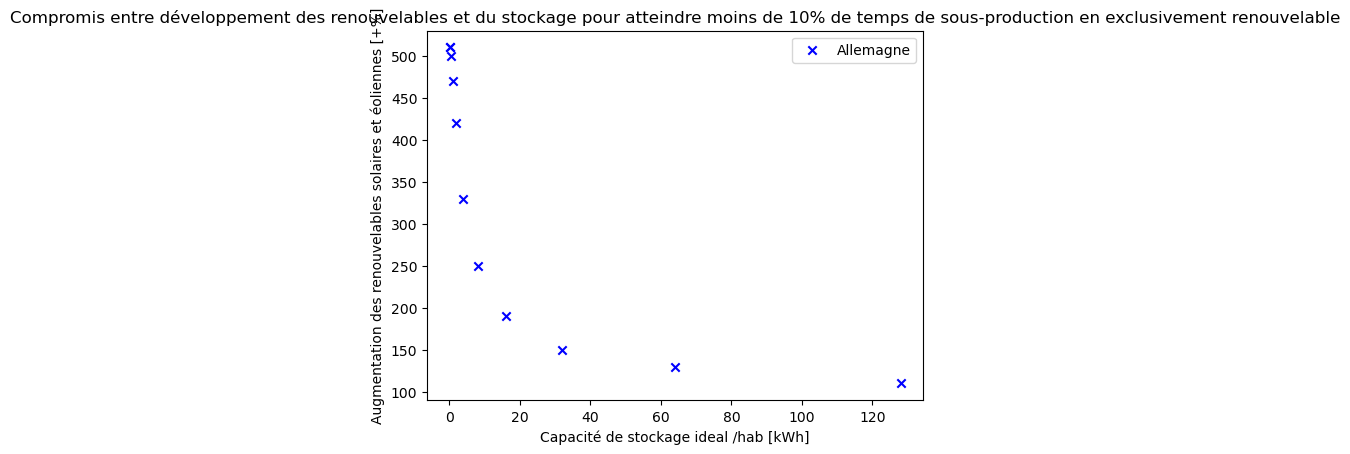

In [26]:
plt.scatter(Eval,ErenIncDE, c='b', marker='x', label='Allemagne')
plt.legend(loc='upper right')
plt.title("Compromis entre développement des renouvelables et du stockage pour atteindre moins de 10% de temps de sous-production en exclusivement renouvelable")
plt.xlabel("Capacité de stockage ideal /hab [kWh]")
plt.ylabel("Augmentation des renouvelables solaires et éoliennes [+%]")
plt.show()

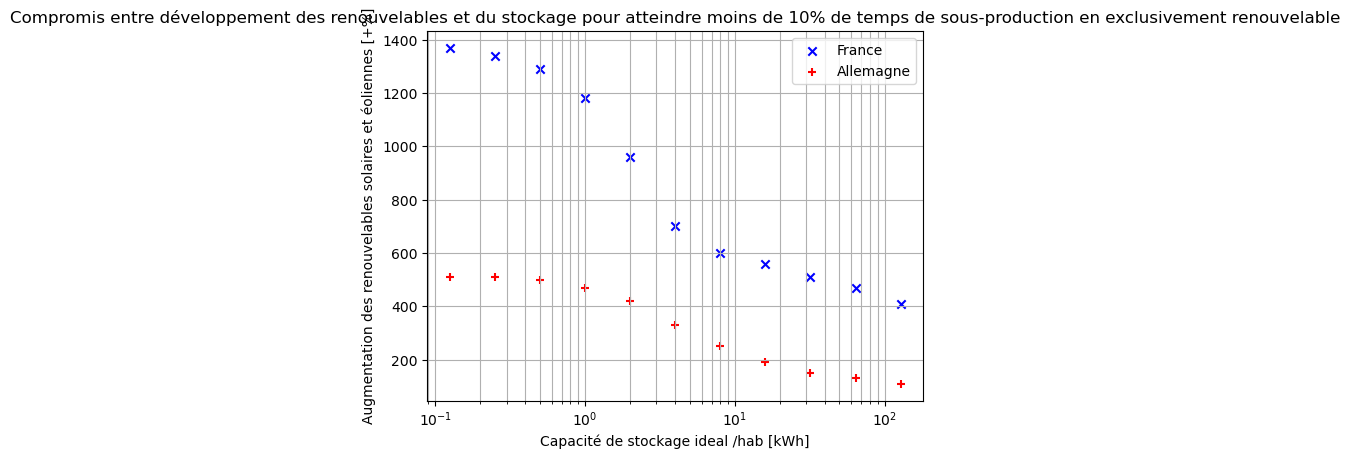

In [27]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(Eval,ErenIncFR, c='b', marker='x', label='France')
ax1.scatter(Eval,ErenIncDE, c='r', marker='+', label='Allemagne')
plt.legend(loc='upper right')
plt.title("Compromis entre développement des renouvelables et du stockage pour atteindre moins de 10% de temps de sous-production en exclusivement renouvelable")
plt.xlabel("Capacité de stockage ideal /hab [kWh]")
plt.ylabel("Augmentation des renouvelables solaires et éoliennes [+%]")
#ax1.set_yscale('log')
ax1.set_xscale('log')
plt.grid(True, which="both")
plt.show()


In [28]:
with open("Eval.json", 'w') as f:
    # indent=2 is not needed but makes the file human-readable 
    # if the data is nested
    json.dump(Eval, f, indent=2) 

In [29]:
with open("ErenIncFR.json", 'w') as f:
    # indent=2 is not needed but makes the file human-readable 
    # if the data is nested
    json.dump(ErenIncFR, f, indent=2) 

In [30]:
with open("ErenIncDE.json", 'w') as f:
    # indent=2 is not needed but makes the file human-readable 
    # if the data is nested
    json.dump(ErenIncDE, f, indent=2) 

In [31]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 665.2661595344543 seconds ---


# Reshape graph

In [32]:
with open("Eval.json", 'r') as f:
    Eval = json.load(f)
#Eval

In [33]:
with open("ErenIncFR.json", 'r') as f:
    ErenIncFR = json.load(f)  
ErenIncFR

[1369.9999999999968,
 1339.999999999997,
 1289.9999999999973,
 1179.9999999999975,
 959.9999999999984,
 699.9999999999992,
 599.9999999999995,
 559.9999999999997,
 509.9999999999999,
 470.0,
 410.0000000000002]

In [34]:
with open("ErenIncDE.json", 'r') as f:
    ErenIncDE = json.load(f)  
#ErenIncDE

In [35]:
colRenScalableFR=[ProdFR.columns[19], ProdFR.columns[21], ProdFR.columns[22]]
colRenScalableDE=[ProdDE.columns[19], ProdDE.columns[21], ProdDE.columns[22]]

In [36]:
timeProdRenScalableFR = ProdFR[colRenScalableFR].sum(numeric_only = True, axis=1)
ErenInitFR = timeProdRenScalableFR.sum()
ErenInitFR

68457326.0

In [37]:
# Incrément de renouvelable par habitant en kWh (/10 pour corriger erreur précédente)
ErenIncFRhab = [(x+1) * ErenInitFR/100/habFR*1000 for x in ErenIncFR]
ErenIncFRhab

[13853.135637785947,
 13550.003566937241,
 13044.783448856062,
 11933.299189077465,
 9710.33066952028,
 7083.186055498147,
 6072.745819335789,
 5668.569724870846,
 5163.349606789667,
 4759.173512324723,
 4152.909370627309]

In [38]:
timeProdRenScalableDE = ProdDE[colRenScalableDE].sum(numeric_only = True, axis=1)
ErenInitDE = timeProdRenScalableDE.sum()/4
ErenInitDE

198235618.0

In [39]:
ErenIncDEhab = [(x+1) * ErenInitDE/100/habDE*1000 for x in ErenIncDE]
ErenIncDEhab

[12082.34742342557,
 12082.34742342557,
 11845.902268368318,
 11136.566803196563,
 9954.34102791031,
 7826.334632395043,
 5934.773391937027,
 4516.102461593514,
 3570.3218413645054,
 3097.4315312500007,
 2624.541221135497]

In [40]:
ErenFRhab = [ErenInitFR/habFR*1000 for x in Eval]
ErenFRhab

[1010.4402361623617,
 1010.4402361623617,
 1010.4402361623617,
 1010.4402361623617,
 1010.4402361623617,
 1010.4402361623617,
 1010.4402361623617,
 1010.4402361623617,
 1010.4402361623617,
 1010.4402361623617,
 1010.4402361623617]

In [41]:
ErenDEhab = [ErenInitDE/habDE*1000 for x in Eval]
ErenDEhab

[2364.451550572519,
 2364.451550572519,
 2364.451550572519,
 2364.451550572519,
 2364.451550572519,
 2364.451550572519,
 2364.451550572519,
 2364.451550572519,
 2364.451550572519,
 2364.451550572519,
 2364.451550572519]

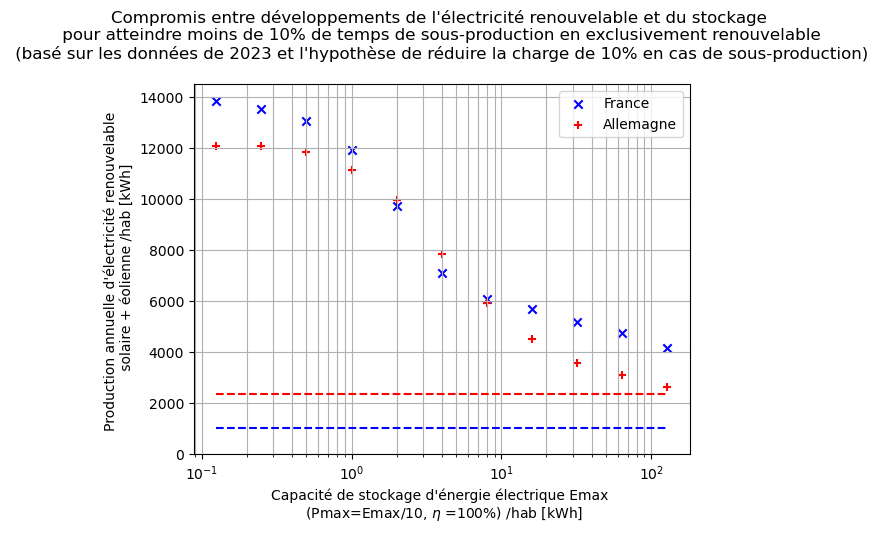

In [42]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(Eval,ErenIncFRhab, c='b', marker='x', label='France')
ax1.plot(Eval, ErenFRhab, c='b', linestyle='dashed')
ax1.scatter(Eval,ErenIncDEhab, c='r', marker='+', label='Allemagne')
ax1.plot(Eval, ErenDEhab, c='r', linestyle='dashed')
plt.legend(loc='upper right')
plt.title("Compromis entre développements de l'électricité renouvelable et du stockage \n pour atteindre moins de 10% de temps de sous-production en exclusivement renouvelable \n (basé sur les données de 2023 et l'hypothèse de réduire la charge de 10% en cas de sous-production) \n")
plt.xlabel("Capacité de stockage d'énergie électrique Emax \n (Pmax=Emax/10, $\eta$ =100%) /hab [kWh]")
plt.ylabel("Production annuelle d'électricité renouvelable \n solaire + éolienne /hab [kWh]")
#ax1.set_yscale('log')
ax1.set_xscale('log')
plt.grid(True, which="both")
ax1.set_ylim(ymin=0)
plt.savefig('Compromis renouvelable stockage (001).png',bbox_inches='tight')
plt.show()